In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
#import pyneb as pn

import numpy as np
import matplotlib.pyplot as plt
import astropy
from astropy.io import fits
from scipy.interpolate import Akima1DInterpolator
from scipy import optimize as opt
import sys
import emcee
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from astropy.table import Table

In [ ]:
def gaussian(x, A, mu, sigma):
    
    '''
    Gaussian Model for Line Fitting
    '''
    
    return A * np.exp(-(x - mu)**2/ (sigma**2))

def line(x, b):
    
    '''
    Continuum of the spectra
    '''
    
    return  np.ones(len(x))*b

def line_model(x, A, mu, sigma, b):
    
    '''
    Emission Line model using Gaussian and the continuum
    '''
    
    return gaussian(x, A, mu, sigma) + line(x, b)


def line_model_OII(x, A1, A2, mu, sigma, b):
    '''
    Emission Line model by double fitting Gaussian and the continuum
    '''
    ratio = 3728.815 / 3726.032
    
    return gaussian(x, A1, mu, sigma) + line(x, b) + gaussian(x, A2, (mu*ratio), sigma)


def log_likelihood(theta, x, y, yerr):
    
    ################
    
    # The value we are trying to fit
    #A, mu, sigma, m, b = theta
    
    #Making the model of the emission line
    model = line_model(x, *theta)
    
    #getting the log likelihood, this is similar to chi2
    lnL = -0.5 * np.sum((y - model) ** 2 / yerr**2)
    
    return lnL

nll = lambda*args: -log_likelihood(*args)

def log_likelihood_OII(theta, x, y, yerr):
    
    ################
    
    # The value we are trying to fit
    #A, mu, sigma, m, b = theta
    
    #Making the model of the emission line
    model = line_model_OII(x, *theta)
    
    #getting the log likelihood, this is similar to chi2
    lnL = -0.5 * np.sum((y - model) ** 2 / yerr**2)
    
    return lnL

nll = lambda*args: -log_likelihood(*args)


def log_prior(theta, wave_center, Amp_max):
    
    #Theta values that goes into our Gaussian Model
    A, mu, sigma,b = theta
    
    #the left most and right most the central wavelength can vary
    left_mu = wave_center -5  #had to change these as well this is how much mu can vary
    right_mu = wave_center +5 #had to change these as well this is how much mu can vary
    
    #min and max amplitude of the emission line
    min_A = 0
    max_A = Amp_max * 2
    
    sigma_window_left = .0001 #had to change these for the input spectra these are left bounds for sigma
    sigma_window_right = 50 #had to change these for the input spectra these are right bounds for sigma
        
    if (0 < A < max_A) & (left_mu <= mu <= right_mu) & (sigma_window_left <= sigma < sigma_window_right) & (b > 0):
        return 0.0
    else:
        return -np.inf
    
def log_prior_OII(theta, wave_center, Amp_max):
    
    #Theta values that goes into our Gaussian Model
    A1, A2, mu, sigma, b = theta
    
    #the left most and right most the central wavelength can vary
    left_mu = wave_center -5  #had to change these as well this is how much mu can vary
    right_mu = wave_center +5 #had to change these as well this is how much mu can vary
    
    #min and max amplitude of the emission line
    min_A = 0
    max_A = Amp_max * 2
    
    sigma_window_left = .0001 #had to change these for the input spectra these are left bounds for sigma
    sigma_window_right = 50 #had to change these for the input spectra these are right bounds for sigma
        
    if (0 < A1 < max_A) & (0 < A2 < max_A) &(left_mu <= mu <= right_mu) & (sigma_window_left <= sigma < sigma_window_right) & (b > 0):
        return 0.0
    else:
        return -np.inf    
    
def log_probability(theta, x, y, yerr, first_wave, Amp_max):
    
    lp = log_prior(theta, first_wave, Amp_max)
    if not np.isfinite(lp):
        #print('Probability is infinite')
        return -np.inf
    prob = lp + log_likelihood(theta, x, y, yerr)
    #print(f'Prob:{prob:.3E}')
    return prob

def log_probability_OII(theta, x, y, yerr, first_wave, Amp_max):
    
    lp = log_prior_OII(theta, first_wave, Amp_max)
    if not np.isfinite(lp):
        #print('Probability is infinite')
        return -np.inf
    prob = lp + log_likelihood_OII(theta, x, y, yerr)
    #print(f'Prob:{prob:.3E}')
    return prob


def initial_fits(wave, spectrum, err_spec, window, line_center, diagnose = False):
    
    window_check = np.log10(window)
    
    #if window_check > -2:
        #print('WARNING: Search window may be too big double check input value')
    
    
    #the range where the optimization can look between 
    min_window = line_center - window
    max_window = line_center + window
    
    #getting emission line near the line center
    #line_center +/- window
    indx = ((min_window < wave) & (wave < max_window))

    spec_window = spectrum[indx]
    wave_window = wave[indx]
    err_spec_window = err_spec[indx]
    
    #initial guesses for the optimization
    guess_A = np.amax(spectrum[indx])
    guess_mu = line_center
    
    spec_interp = Akima1DInterpolator(wave_window, spec_window)
    
    x = np.linspace(wave_window[0], wave_window[-1], 10000)
    
    spec = spec_interp(x)
    
    half_max = np.amax(spec)/2
    
    idx = np.where(spec > half_max)[0]
    
    wave_left, wave_right = x[idx[0]], x[idx[-1]]
    
    guess_sigma = (wave_right - wave_left)/2
    
    if diagnose == True:
        
        print('Minimization Guesses')
        print(f"A: {guess_A}")
        print(f"mu: {guess_mu}")
        print(f"sigma: {guess_sigma}")
        print(f"b: {np.median(spec_window)}")
        print() 
        
    if np.median(spec_window) < 0:
        low_bound_negative = np.median(spec_window)*2
        high_bound_negative = np.median(spec_window)/2
        low_bounds = [0, min_window, 0, low_bound_negative]
        high_bounds = [2*guess_A, max_window, 50, high_bound_negative]
    
    else:
        low_bound_positive = np.median(spec_window)/2
        high_bound_positive = np.median(spec_window)*2
        low_bounds = [0, min_window, 0, low_bound_positive]
        high_bounds = [2*guess_A, max_window, 50, high_bound_positive]
    
        
    x0 = [guess_A, guess_mu, guess_sigma, np.median(spec_window)]
    
#     low_bounds = [0, min_window, 0, np.median(spec_window)/2]
#     high_bounds = [2*guess_A, max_window, .005, np.median(spec_window)*2]
    #print('low bounds',low_bounds)
    #print('high bounds',high_bounds)
    #print(x0,'x0')
    # Optimization of the initial gaussian fit
    #plt.figure()
   # plt.plot(wave_window, spec_window)
    result,_ = curve_fit(line_model, wave_window, spec_window, p0 = x0, 
                          bounds = [low_bounds, high_bounds])                 
    #bounds on b
    
    
    ########
    # Diagnostic Plotting: making sure we are getting the emission line
    ########
    if diagnose == True:
        
        print('Minimization Results')
        print(f"A: {result[0]}")
        print(f"mu: {result[1]}")
        print(f"sigma: {result[2]}")
        print(f"b: {result[3]}")
        print()
        
        xarr = np.linspace(wave_window[0], wave_window[-1], 100)
        plt.figure()
        plt.plot(wave_window, spec_window, color = 'blue', label = 'Data')
        plt.scatter(wave_window, spec_window, color = 'blue')
        plt.plot(xarr, line_model(xarr, *result), color = 'black', label = 'Model')
        plt.axhline(0, linestyle = '--')
        plt.ylabel('Flux')
        plt.xlabel(r'Wavelength $\mu$m')
        plt.title('Initial curve_fit Fitting')
        plt.legend()
        plt.show()
    
    
    return result



def initial_fits_OII(wave, spectrum, err_spec, window, line_center, diagnose = False):
    
    window_check = np.log10(window)
    
    #if window_check > -2:
        #print('WARNING: Search window may be too big double check input value')
    
    
    #the range where the optimization can look between 
    min_window = line_center - window
    max_window = line_center + window
    
    #getting emission line near the line center
    #line_center +/- window
    indx = np.where((min_window < wave) & ((wave < max_window)))[0]

    spec_window = spectrum[indx]
    wave_window = wave[indx]
    err_spec_window = err_spec[indx]
    
    #initial guesses for the optimization
    guess_A1= np.amax(spectrum[indx])
    guess_A2= np.amax(spectrum[indx])

    guess_mu = line_center
    
    spec_interp = Akima1DInterpolator(wave_window, spec_window)
    
    x = np.linspace(wave_window[0], wave_window[-1], 10000)
    
    spec = spec_interp(x)
    
    half_max = np.amax(spec)/2
    
    idx = np.where(spec > half_max)[0]
    
    wave_left, wave_right = x[idx[0]], x[idx[-1]]
    
    guess_sigma = (wave_right - wave_left)/4
    
    if diagnose == True:
        
        print('Minimization Guesses')
        print(f"A1: {guess_A1}")
        print(f"A2: {guess_A2}")
        print(f"mu: {guess_mu}")
        print(f"sigma: {guess_sigma}")
        print(f"b: {np.median(spec_window)}")
        print() 
        
    if np.median(spec_window) < 0:
        low_bound_negative = np.median(spec_window)*2
        high_bound_negative = np.median(spec_window)/2
        low_bounds = [0, 0,min_window, 0, low_bound_negative]
        high_bounds = [2*guess_A1,2*guess_A2, max_window, 50, high_bound_negative]
    
    else:
        low_bound_positive = np.median(spec_window)/2
        high_bound_positive = np.median(spec_window)*2
        low_bounds = [0,0, min_window, 0, low_bound_positive]
        high_bounds = [2*guess_A1,2*guess_A2, max_window, 50, high_bound_positive]
    
        
    x0 = [guess_A1, guess_A2, guess_mu, guess_sigma, np.median(spec_window)]
    
#     low_bounds = [0, min_window, 0, np.median(spec_window)/2]
#     high_bounds = [2*guess_A, max_window, .005, np.median(spec_window)*2]
    #print('low bounds',low_bounds)
    #print('high bounds',high_bounds)
    #print(x0,'x0')
    # Optimization of the initial gaussian fit
    #plt.figure()
   # plt.plot(wave_window, spec_window)
    result,_ = curve_fit(line_model_OII, wave_window, spec_window, p0 = x0, 
                          bounds = [low_bounds, high_bounds])                 
    #bounds on b
    
    
    ########
    # Diagnostic Plotting: making sure we are getting the emission line
    ########
    if diagnose == True:
        
        print('Minimization Results')
        print(f"A1: {result[0]}")
        print(f"A2: {result[1]}")
        print(f"mu: {result[2]}")
        print(f"sigma: {result[3]}")
        print(f"b: {result[4]}")
        print()
        
        xarr = np.linspace(wave_window[0], wave_window[-1], 100)
        plt.figure()
        plt.plot(wave_window, spec_window, color = 'blue', label = 'Data')
        plt.scatter(wave_window, spec_window, color = 'blue')
        plt.plot(xarr, line_model_OII(xarr, *result), color = 'black', label = 'Model')
        plt.axhline(0, linestyle = '--')
        plt.ylabel('Flux')
        plt.xlabel(r'Wavelength $\mu$m')
        plt.title('Initial curve_fit Fitting')
        plt.legend()
        plt.show()
    
    
    return result




def old_fitting_line(wave, flux, flux_err, line_center, window_wavelength, 
                 diagnose = False,save=True, filename = 'Emcee_Chains_Galaxy.txt'):
    
    result = initial_fits(wave, flux, flux_err, window_wavelength, line_center, diagnose = diagnose)
    
    #getting the results from the initial fit to then pass into emcee
    guess_A = result[0]
    guess_mu = result[1]
    guess_sigma = result[2]
    guess_b = result[3]
    
    
    #making walkers so that we can use emcee to explore the parameter space
    #centered on the best results from minimization
    amp_jump = np.random.normal(loc = guess_A,            #centered on best A from minimization
                                scale = guess_A/10,       #can wander 1/10 of the value of A
                                size = 32).reshape(-1, 1) 
    
    wavelength_jump = np.random.normal(loc = guess_mu,    #centered on best mu from minimization
                                       scale = .005,      #can wander +/- 0.005 microns 
                                       size = 32).reshape(-1, 1)
    
    sigma_jump = np.random.normal(loc = guess_sigma, scale = .002, size = 32).reshape(-1, 1)

    
    powerb = np.log10(np.abs(guess_b))
    
    b_jump = np.random.normal(loc = guess_b, scale = 1*10**powerb, size = 32).reshape(-1, 1)

    
    #################
    # Diagnostic plotting to see if the parameters were jumping to large values
    # The should be concentrated near their best fit results values
    #################
    if diagnose == True:
        print('Checking the Walker Jumps')
        fig, ax = plt.subplots(nrows = 2, ncols = 2, constrained_layout = True)
        
        ax[0, 0].hist(amp_jump)
        ax[0, 0].set_xlabel('Amplitude')
        
        ax[0, 1].hist(wavelength_jump)
        ax[0, 1].set_xlabel(r'$\mu$')
        
        ax[1, 0].hist(sigma_jump)
        ax[1, 0].set_xlabel(r'$\sigma$')
        
        ax[1, 1].hist(b_jump)
        ax[1, 1].set_xlabel('b')
        
        plt.show()
    

    #stacking along the columns
    starting_walkers = np.hstack((amp_jump,
                                  wavelength_jump, 
                                  sigma_jump, 
                                  #m_jump, 
                                  b_jump))

    #initializing window for emcee around the best result mu
    emcee_window = window_wavelength #in units of microns
    emcee_indx = np.where((wave >= (line_center - emcee_window)) & 
                          (wave <= (line_center + emcee_window)))[0]

    #emcee subsections
    emcee_spec = flux[emcee_indx]
    emcee_wave = wave[emcee_indx]
    emcee_err = flux_err[emcee_indx]
    
    
    ###########
    #NOTE:
    #need to change output name everytime you run otherwise it will overwrite
    ###########
    
    #saves the input emcee spectra
    emcee_spec_matrix = np.c_[emcee_wave, emcee_spec, emcee_err]
    #np.savetxt(f'Emcee_Spectra.txt', emcee_spec_matrix)

    #initializing walker positions
    pos = starting_walkers
    nwalkers, ndim = pos.shape

    #initializing sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                                    args=(emcee_wave, emcee_spec, emcee_err, guess_mu, guess_A), 
                                    moves = [(emcee.moves.DEMove(), 0.5),
                                             (emcee.moves.DESnookerMove(), 0.5)])

    #running it
    sampler.run_mcmc(pos, 3000, progress=False)

    #getting values back
    #samples = sampler.get_chain()
    flat_samples = sampler.get_chain(flat=True)
    LnL_chain = sampler.flatlnprobability
    burn_in = 1000 
    
    emcee_df = pd.DataFrame()
    emcee_df['A'] = flat_samples[burn_in:, 0]
    emcee_df['mu'] = flat_samples[burn_in:, 1]
    emcee_df['sigma'] = flat_samples[burn_in:, 2]
    emcee_df['b'] = flat_samples[burn_in:, 3]
    emcee_df['LnL'] = LnL_chain[burn_in:]
    
    emcee_df = emcee_df[np.isfinite(emcee_df.LnL.values)]
    
    fluxes_emcee = emcee_df['A'] * emcee_df['sigma'] * np.sqrt(2 * np.pi)
    
    emcee_df['Fluxes'] = fluxes_emcee
    
    if diagnose == True:
        
        print('Checking Prameter Posterior Distributions')
        fig, ax = plt.subplots(nrows = 2, ncols = 2, constrained_layout = True)
        
        emcee_df.A.hist(ax = ax[0, 0])
        emcee_df.mu.hist(ax = ax[0, 1])
        emcee_df.sigma.hist(ax = ax[1, 0])
        #emcee_df.m.hist(ax = ax[1, 0])
        emcee_df.b.hist(ax = ax[1, 1])
        
        plt.show()
    
    if diagnose == True:
        xarr = np.linspace(emcee_wave[0], emcee_wave[-1], 100)
        
        plt.figure()
        plt.title('Input Emcee Spectra and Emcee Fit')
        plt.plot(emcee_wave, emcee_spec, color = 'black', alpha = 0.5, label = 'Data')
        plt.scatter(emcee_wave, emcee_spec, color = 'black')
        plt.plot(xarr, line_model(xarr, *emcee_df.quantile(q = 0.5).values[:-2]), label = 'Model')
        plt.xlabel(r'Wavelength [$\mu$m]')
        plt.ylabel('Flux')
        plt.legend()
        plt.show()
    
    if diagnose == True:
        plt.figure()
        #xarr = np.linspace(emcee_wave[0], emcee_wave[-1], 100)
        plt.title('Residual (Data - Model)')
        #plt.plot(emcee_wave, emcee_spec, color = 'black', alpha = 0.5, label = 'Data')
        #plt.scatter(emcee_wave, emcee_spec, color = 'black')
        plt.plot(emcee_wave, line_model(emcee_wave, *emcee_df.quantile(q = 0.5).values[:-2])-emcee_spec, label = 'Model')
        plt.xlabel(r'Wavelength [$\mu$m]')
        plt.ylabel('Residual Flux')
        plt.legend()
        print(np.abs( np.mean(line_model(emcee_wave, *emcee_df.quantile(q = 0.5).values[:-2])-emcee_spec)))
        plt.show()
    ###########
    #NOTE:
    #need to also give the filename argument otherwise it will overwrite the default file
    ###########
    if save == True:
        emcee_df.to_csv(filename, sep = ' ')
        
    else:
        return emcee_wave, emcee_spec, emcee_err, emcee_df

    
    
    
    
def fitting_line_OII(wave, flux, flux_err, line_center, window_wavelength, 
                 diagnose = False,save=True, filename = 'Emcee_Chains_Galaxy.txt'):
    
    result = initial_fits_OII(wave, flux, flux_err, window_wavelength, line_center, diagnose = diagnose)
    
    #getting the results from the initial fit to then pass into emcee
    guess_A1 = result[0]
    guess_A2 = result[1]
    guess_mu = result[2]
    guess_sigma = result[3]
    guess_b = result[4]
    
    
    #making walkers so that we can use emcee to explore the parameter space
    #centered on the best results from minimization
    amp_jump1 = np.random.normal(loc = guess_A1,            #centered on best A from minimization
                                scale = guess_A1/10,       #can wander 1/10 of the value of A
                                size = 32).reshape(-1, 1) 
    amp_jump2 = np.random.normal(loc = guess_A2,            #centered on best A from minimization
                            scale = guess_A2/10,       #can wander 1/10 of the value of A
                            size = 32).reshape(-1, 1) 

    wavelength_jump = np.random.normal(loc = guess_mu,    #centered on best mu from minimization
                                       scale = .005,      #can wander +/- 0.005 microns 
                                       size = 32).reshape(-1, 1)
    
    sigma_jump = np.random.normal(loc = guess_sigma, scale = .002, size = 32).reshape(-1, 1)

    
    powerb = np.log10(np.abs(guess_b))
    
    b_jump = np.random.normal(loc = guess_b, scale = 1*10**powerb, size = 32).reshape(-1, 1)

    
    #################
    # Diagnostic plotting to see if the parameters were jumping to large values
    # The should be concentrated near their best fit results values
    #################
    if diagnose == True:
        print('Checking the Walker Jumps')
        fig, ax = plt.subplots(nrows = 2, ncols = 3, constrained_layout = True)
        
        ax[0, 0].hist(amp_jump1)
        ax[0, 0].set_xlabel('Amplitude1')
        
        ax[0, 1].hist(amp_jump2)
        ax[0, 1].set_xlabel('Amplitude2')   
        
        ax[1, 0].hist(wavelength_jump)
        ax[1, 0].set_xlabel(r'$\mu$')
        
        ax[1, 1].hist(sigma_jump)
        ax[1, 1].set_xlabel(r'$\sigma$')
        
        ax[1, 2].hist(b_jump)
        ax[1, 2].set_xlabel('b')
        
        plt.show()
    

    #stacking along the columns
    starting_walkers = np.hstack((amp_jump1,amp_jump2,
                                  wavelength_jump, 
                                  sigma_jump, 
                                  #m_jump, 
                                  b_jump))

    #initializing window for emcee around the best result mu
    emcee_window = window_wavelength #in units of microns
    emcee_indx = np.where((wave >= (line_center - emcee_window)) & 
                          (wave <= (line_center + emcee_window)))[0]

    #emcee subsections
    emcee_spec = flux[emcee_indx]
    emcee_wave = wave[emcee_indx]
    emcee_err = flux_err[emcee_indx]
    
    
    ###########
    #NOTE:
    #need to change output name everytime you run otherwise it will overwrite
    ###########
    
    #saves the input emcee spectra
    emcee_spec_matrix = np.c_[emcee_wave, emcee_spec, emcee_err]
    #np.savetxt(f'Emcee_Spectra.txt', emcee_spec_matrix)

    #initializing walker positions
    pos = starting_walkers
    nwalkers, ndim = pos.shape

    #initializing sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_OII, 
                                    args=(emcee_wave, emcee_spec, emcee_err, guess_mu, guess_A1), 
                                    moves = [(emcee.moves.DEMove(), 0.5),
                                             (emcee.moves.DESnookerMove(), 0.5)])

    #running it
     
    burn_in = 1000 
    state = sampler.run_mcmc(pos, burn_in, progress=False)
    sampler.reset()
    sampler.run_mcmc(state, 3000, progress=False)
    #getting values back
    #samples = sampler.get_chain()
    #flat_samples = sampler.get_chain(flat=True)
   # LnL_chain = sampler.flatlnprobability
    

    
    emcee_df = pd.DataFrame()
    emcee_df['A1'] = flat_samples[:, 0]
    emcee_df['A2'] = flat_samples[:, 1]
    emcee_df['mu'] = flat_samples[:, 2]
    emcee_df['sigma'] = flat_samples[:, 3]
    emcee_df['b'] = flat_samples[:, 4]
    emcee_df['LnL'] = LnL_chain[:]
    
    emcee_df = emcee_df[np.isfinite(emcee_df.LnL.values)]
    
    fluxes_emcee1 = emcee_df['A1'] * emcee_df['sigma'] * np.sqrt(2 * np.pi)
    fluxes_emcee2 = emcee_df['A2'] * emcee_df['sigma'] * np.sqrt(2 * np.pi)

    emcee_df['Fluxes_OII3727'] = fluxes_emcee1
    emcee_df['Fluxes_OII3729'] = fluxes_emcee2
    
    if diagnose == True:
        
        print('Checking Prameter Posterior Distributions')
        fig, ax = plt.subplots(nrows = 2, ncols = 2, constrained_layout = True)
        
        emcee_df.A.hist(ax = ax[0, 0])
        emcee_df.mu.hist(ax = ax[0, 1])
        emcee_df.sigma.hist(ax = ax[1, 0])
        #emcee_df.m.hist(ax = ax[1, 0])
        emcee_df.b.hist(ax = ax[1, 1])
        
        plt.show()
    
    if diagnose == True:
        xarr = np.linspace(emcee_wave[0], emcee_wave[-1], 100)
        
        plt.figure()
        plt.title('Input Emcee Spectra and Emcee Fit')
        plt.plot(emcee_wave, emcee_spec, color = 'black', alpha = 0.5, label = 'Data')
        plt.scatter(emcee_wave, emcee_spec, color = 'black')
        plt.plot(xarr, line_model(xarr, *emcee_df.quantile(q = 0.5).values[:-2]), label = 'Model')
        plt.xlabel(r'Wavelength [$\mu$m]')
        plt.ylabel('Flux')
        plt.legend()
        plt.show()
    
    if diagnose == True:
        plt.figure()
        #xarr = np.linspace(emcee_wave[0], emcee_wave[-1], 100)
        plt.title('Residual (Data - Model)')
        #plt.plot(emcee_wave, emcee_spec, color = 'black', alpha = 0.5, label = 'Data')
        #plt.scatter(emcee_wave, emcee_spec, color = 'black')
        plt.plot(emcee_wave, line_model(emcee_wave, *emcee_df.quantile(q = 0.5).values[:-2])-emcee_spec, label = 'Model')
        plt.xlabel(r'Wavelength [$\mu$m]')
        plt.ylabel('Residual Flux')
        plt.legend()
        print(np.abs( np.mean(line_model(emcee_wave, *emcee_df.quantile(q = 0.5).values[:-2])-emcee_spec)))
        plt.show()
    ###########
    #NOTE:
    #need to also give the filename argument otherwise it will overwrite the default file
    ###########
    if save == True:
        emcee_df.to_csv(filename, sep = ' ')
        
    else:
        return emcee_wave, emcee_spec, emcee_err, emcee_df


In [ ]:
OIII4960 = 4958.911
OIII5007 = 5006.843
OIII4363 = 4363.210
h_beta = 4861.333
h_alpha = 6562.819
SII6716 = 6716.440
SII6731 = 6730.810
OII3726= 3726.032
OII3729= 3728.815

In [ ]:
main_table = Table.read('MAIN_TABLE_CORRECTED.fits')

obs_wavelength = main_table['OBS_WAVELENGTH']
redshift = main_table['NEW_REDSHIFT']
flux = main_table['FLUX']
source_name = main_table['SOURCE_NAME']
flux_error = main_table['FLUX_ERROR']
flags = main_table['FLAGS']

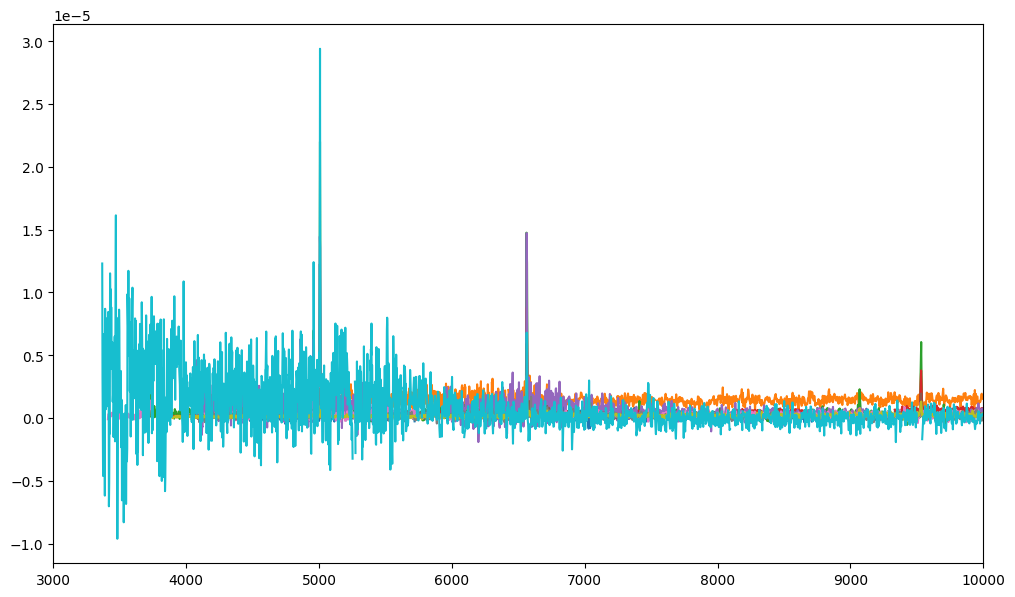

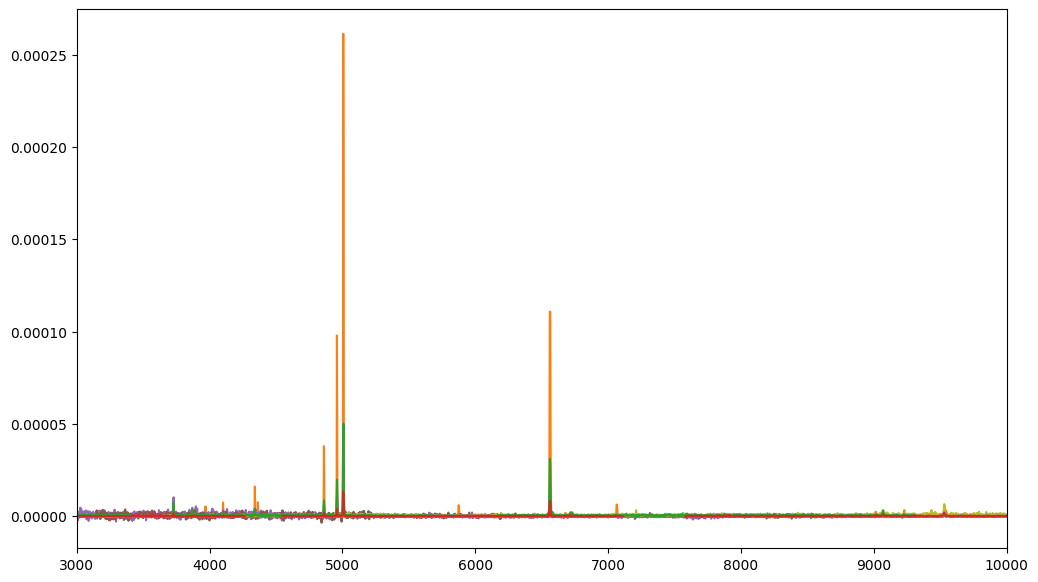

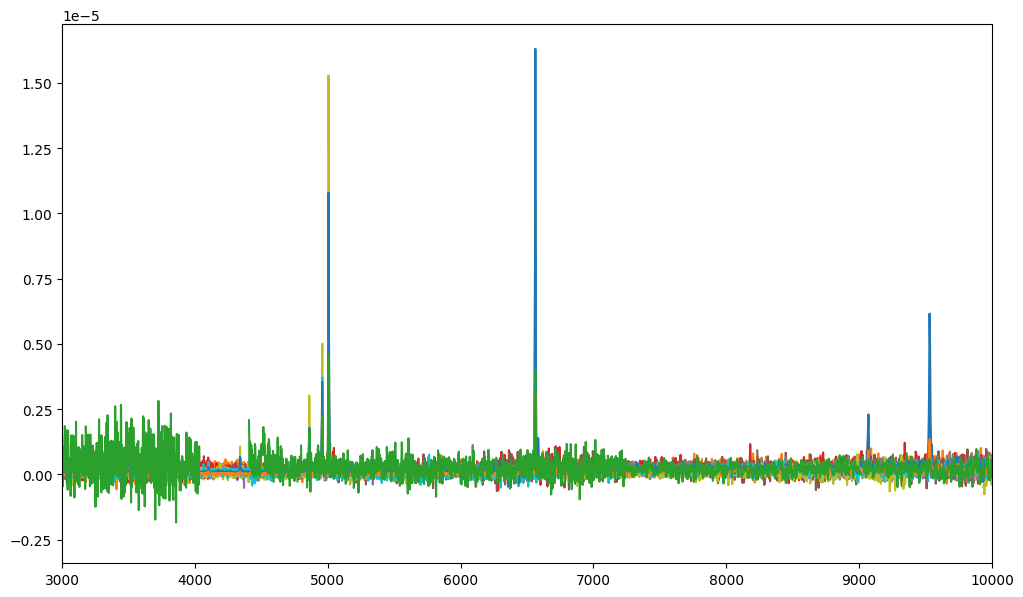

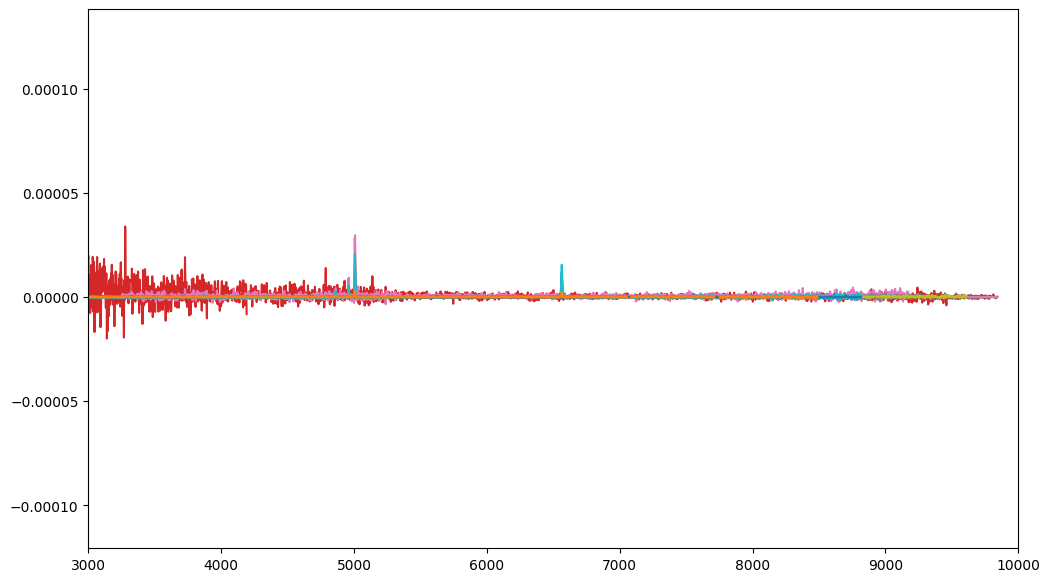

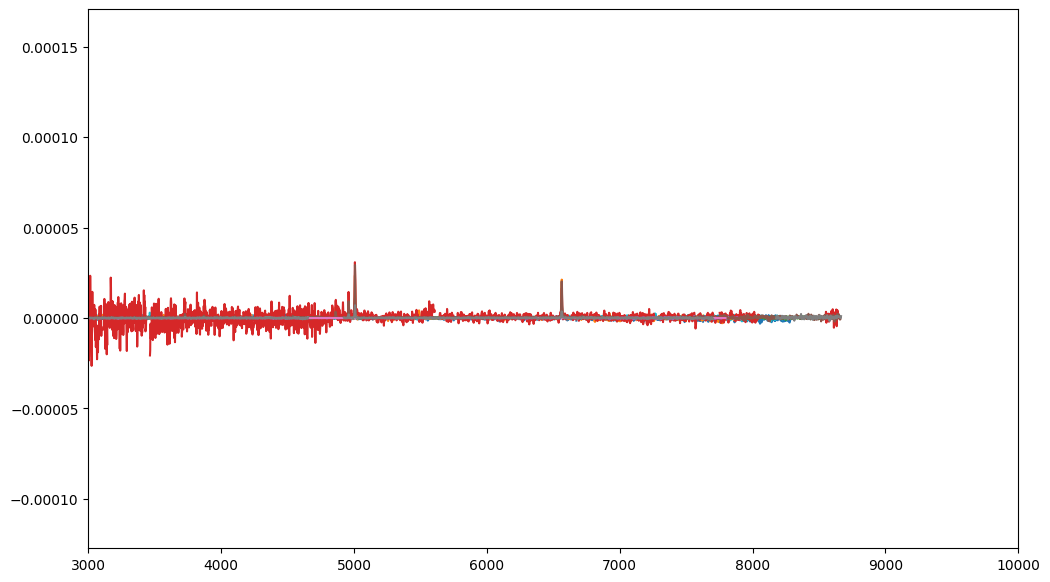

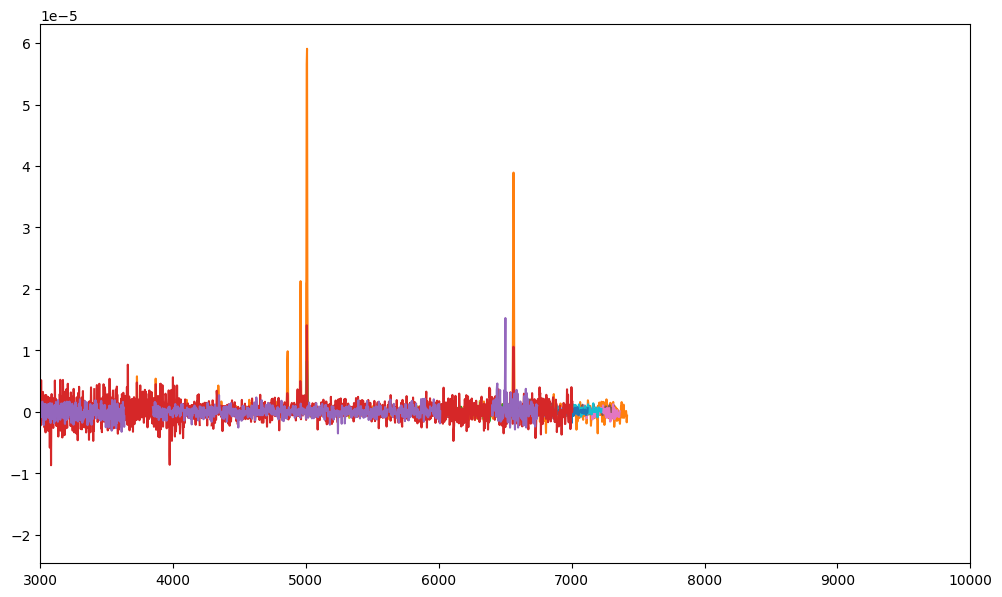

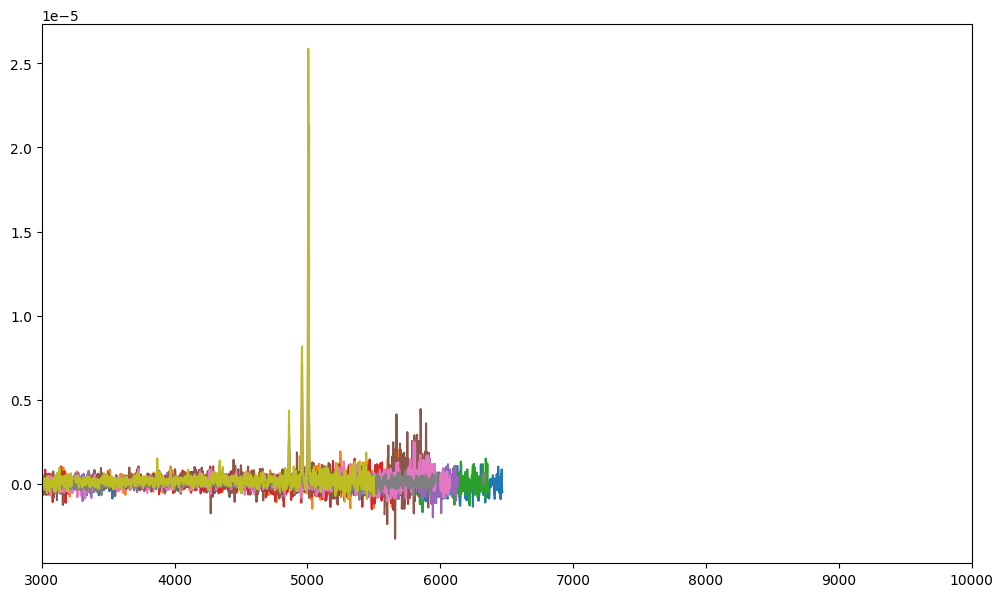

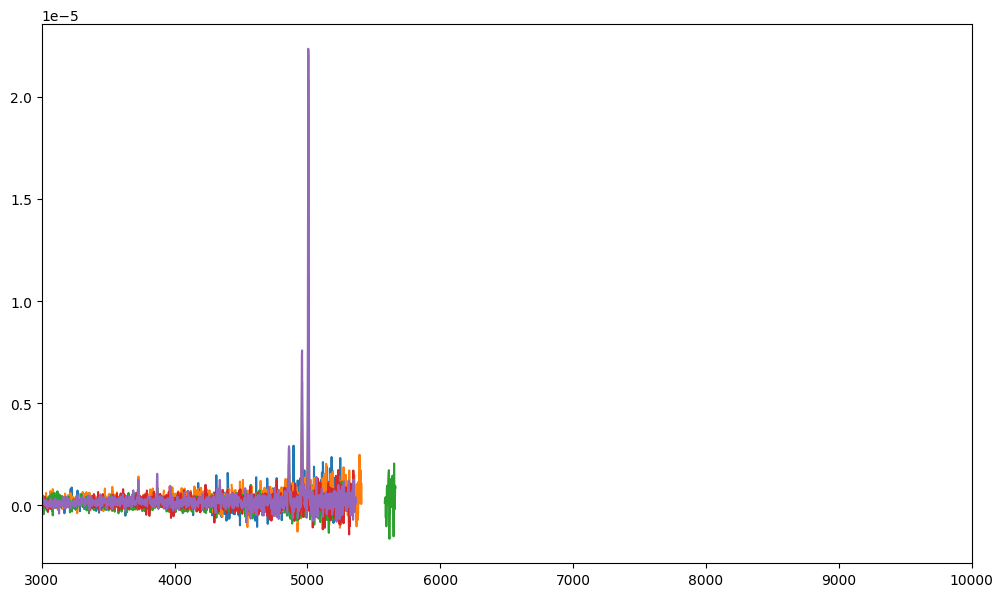

<Figure size 1200x700 with 0 Axes>

In [ ]:
# for i in range(1, 10):
#     z_mask = (main_table['NEW_REDSHIFT'] > i) & (main_table['NEW_REDSHIFT'] < i+1) & (main_table['R VALUES'] == "Yes") & (main_table['FLAGS']==True)
#     check = main_table[z_mask]

#     plt.figure(figsize = (12, 7))
#     for x, y in zip(check['REST_FRAME_WAVELENGTH']*10000, check['FLUX_INSTRINSIC']):
#         plt.plot(x, y)
#         plt.xlim(3000, 10000)
#     plt.show()

## random sampling with replacement

In [ ]:
def OIII_ratio(oiii4363, oiii4960, oiii5007):
    """Calculate the logarithmic OIII ratio."""
    ratio = np.log10(oiii4363 / (oiii4960 + oiii5007))
    return ratio

def effective_temp(x):
    """Calculate the effective temperature from the OIII ratio."""
    log_Te = (3.5363 + 7.2939 * x) / (1.0000 + 1.6298 * x - 0.1221 * (x ** 2) - 0.0074 * (x ** 3))
    T_e = 10 ** log_Te
    return T_e

def metallicity(T_e):
    """Calculate the metallicity as 12 + log(O/H)."""
    t_e = T_e / 1e4  # Scale temperature to 10^4 K units
    O_H = 9.72 - 1.7 * t_e + 0.32 * (t_e ** 2)
    return O_H

In [7]:
#SLOW CODE
''' 
import numpy as np
from astropy.io import fits
import time
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline

n_bootstrap = 2
# Load data
confirmed_redshifts_for_filtered_restframe = main_table['NEW_REDSHIFT'].value
names_for_filtered_restframe = main_table['SOURCE_NAME']
wavelength = (main_table['REST_FRAME_WAVELENGTH'].value) *10000
flux = main_table['FLUX_INSTRINSIC'].value
flux_error = main_table['FLUX_ERROR_CORRECTED'].value
R_values = main_table['R VALUES']
flags = main_table['FLAGS']
wt_avg_master = []
wt_err_master = []
stacked_wavelength = []
def removebad(flux, flux_error):
    flux_nan = ~np.isnan(flux)
    flux_error_nan = ~np.isnan(flux_error)
    master_mask = flux_nan & flux_error_nan
    return master_mask

for k in range(1, 10):
    z_mask = (confirmed_redshifts_for_filtered_restframe > k) & (confirmed_redshifts_for_filtered_restframe < k+1) & (R_values == 'Yes') & (flags==True)
    check = main_table[z_mask]


    cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)

    wavemin = 2000
    wavemax = 10000
    delwave = .01 # in AA
    gridwl = np.arange(wavemin, wavemax, delwave)
    nwave = len(gridwl)

    speccount = len(check)
    
    if speccount == 0:
        continue

    
    specall = np.zeros((nwave, speccount)) # speccount is # of galaxies in bin that we are stacking
    specerrall = np.zeros((nwave, speccount))  # for ex, speccount is # of galaxies between 2-3 redshift 
    
    t0 = time.time()
    
#     selected_spectra_flux_error = []
#     selected_spectra_redshift = []
#     selected_spectra_wavelength = []
#     selected_spectra_flux = []
    
    for b in range(n_bootstrap):
        rand_idx = np.random.randint(0, speccount, size=speccount)
        
        rand_redshift = check["NEW_REDSHIFT"][rand_idx]
        rand_flux = check["FLUX_INSTRINSIC"][rand_idx]
        rand_flux_error = check["FLUX_ERROR_CORRECTED"][rand_idx]
        rand_wavelength = check["REST_FRAME_WAVELENGTH"][rand_idx]
        
        for i in range(speccount):
            
            redshift = rand_redshift[i]

            # Access individual spectrum for the current galaxy
            current_flux = rand_flux[i]  # flux[i] is a 1D array for this galaxy
            current_flux_error = rand_flux_error[i]  # flux_error[i] is a 1D array for this galaxy
            current_wavelength = (rand_wavelength*10000)[i]  # corresponding wavelength array for this galaxy

            # Remove bad pixels using removebad function
            goodpix = removebad(current_flux, current_flux_error)
            current_flux = current_flux[goodpix]
            current_flux_error = current_flux_error[goodpix]
            current_wavelength = current_wavelength[goodpix]  # Apply goodpix to current_wavelength

            # Subtract continuum
            continuum = signal.medfilt(current_flux, kernel_size=951)
            subtract_continuum = current_flux - continuum
            #subtract_continuum_flux_error = current_flux_error - continuum

            ldist = cosmo.luminosity_distance(redshift).to(u.cm)  # Compute luminosity distance
            lspec = ldist * ldist * 4 * np.pi * (1 + redshift) * subtract_continuum
            lspecerr = ldist * ldist * 4 * np.pi * (1 + redshift) * current_flux_error  # Luminosity error

            UNDEF = -999.
            gridspec = np.interp(gridwl, current_wavelength, lspec.value, left=UNDEF, right=UNDEF)  # Interpolating the flux
            gridspecerr = np.interp(gridwl, current_wavelength, lspecerr.value, left=UNDEF, right=UNDEF)  # Interpolating the error
            specall[:, i] = gridspec
            specerrall[:, i] = gridspecerr

        wt_avg = np.zeros(nwave)
        wt_err = np.zeros(nwave)

            # Stacking
        for j in range(nwave):  # to stack pixels
            speccol = specall[j, :]
            specerrcol = specerrall[j, :]
            good = np.where(speccol != UNDEF)
            ngood = len(speccol[good])

            if ngood == 0:
                continue  # If no good pixels, skip

            speccol = speccol[good]
            specerrcol = specerrcol[good]

            weight = 1 / (specerrcol * specerrcol)
            wt_avg[j] = np.nansum(speccol * weight) / np.nansum(weight)
            wt_err[j] = np.sqrt(1. / np.nansum(weight))

        wt_avg_master.append(wt_avg)    
        wt_err_master.append(wt_err)    
        stacked_wavelength.append(gridwl)

        # Plot the weighted average stacked spectrum for each bin
        #z_range = key.replace('_', '<z<')
        plt.figure(figsize=(10, 3))
        plt.axvline(OIII4960, c='k', label='OIII4960', linewidth=.5, ls='--', alpha=0.6)
        plt.text(OIII4960 - 150, max(wt_avg) * 0.7, 'OIII4960', rotation=90, verticalalignment='bottom', alpha=0.6)

        plt.axvline(OIII5007, c='k', label='OIII5007', linewidth=.5, ls='--', alpha=0.4)
        plt.text(OIII5007 + 100, max(wt_avg) * 0.7, 'OIII5007', rotation=90, verticalalignment='bottom', alpha=0.6)

        plt.axvline(OIII4363, c='k', label='OIII4363', linewidth=.5, ls='--', alpha=0.4)
        plt.text(OIII4363 + 75, max(wt_avg) * 0.7, 'OIII4363', rotation=90, verticalalignment='bottom', alpha=0.6)

        plt.plot(gridwl, wt_avg, lw=1, c='teal')
        plt.xlim(3000, 10000)
        plt.title(f'Stacked Spectra for {k} < z < {k+1}')
        plt.xlabel('Wavelength')
        plt.ylabel('Weighted Average')
        plt.show()
'''

' \nimport numpy as np\nfrom astropy.io import fits\nimport time\nfrom astropy.cosmology import FlatLambdaCDM\nimport astropy.units as u\nfrom scipy import signal\nimport matplotlib.pyplot as plt\n%matplotlib inline\n\nn_bootstrap = 2\n# Load data\nconfirmed_redshifts_for_filtered_restframe = main_table[\'NEW_REDSHIFT\'].value\nnames_for_filtered_restframe = main_table[\'SOURCE_NAME\']\nwavelength = (main_table[\'REST_FRAME_WAVELENGTH\'].value) *10000\nflux = main_table[\'FLUX_INSTRINSIC\'].value\nflux_error = main_table[\'FLUX_ERROR_CORRECTED\'].value\nR_values = main_table[\'R VALUES\']\nflags = main_table[\'FLAGS\']\nwt_avg_master = []\nwt_err_master = []\nstacked_wavelength = []\ndef removebad(flux, flux_error):\n    flux_nan = ~np.isnan(flux)\n    flux_error_nan = ~np.isnan(flux_error)\n    master_mask = flux_nan & flux_error_nan\n    return master_mask\n\nfor k in range(1, 10):\n    z_mask = (confirmed_redshifts_for_filtered_restframe > k) & (confirmed_redshifts_for_filtered_rest

conducting orders of operations on array of the same length is a faster process that creating for loops. for 10/30, work on adding metallicity and old_fitting_line function onto the stacking code. 1000 metallcity saved into 1 array. then do 16%, 50%, 84%.

In [8]:
confirmed_redshifts_for_filtered_restframe = main_table['NEW_REDSHIFT'].value
names_for_filtered_restframe = main_table['SOURCE_NAME']
wavelength = (main_table['REST_FRAME_WAVELENGTH'].value) *10000
flux = main_table['FLUX_INSTRINSIC'].value
flux_error = main_table['FLUX_ERROR_CORRECTED'].value
R_values = main_table['R VALUES']
flags = main_table['FLAGS']


In [32]:
# Bootstrap iterations
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from scipy import signal

# Constants and initializations
n_bootstrap = 2
wavemin, wavemax, delwave = 2000, 10000, 0.01
gridwl = np.arange(wavemin, wavemax, delwave)
nwave = len(gridwl)
q_master = []

cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)
scaling_factor_const = 4 * np.pi  # Precompute constant factor
all_metallicities = []

# Precompute the wavelength grid
stacked_spectra, stacked_errors = [], []

def removebad(flux, flux_error):
    return ~np.isnan(flux) & ~np.isnan(flux_error)

for k in range(1, 10):
    z_mask = (confirmed_redshifts_for_filtered_restframe > k) & \
             (confirmed_redshifts_for_filtered_restframe < k + 1) & \
             (R_values == 'Yes') & (flags == True)
    check = main_table[z_mask]
    speccount = len(check)

    if speccount == 0:
        continue

    # Initialize arrays for stacking spectra
    redshifts = check["NEW_REDSHIFT"]
    flux_data = check["FLUX_INSTRINSIC"]
    flux_error_data = check["FLUX_ERROR_CORRECTED"]
    wavelengths = (check["REST_FRAME_WAVELENGTH"] * 10000)

    # Precompute luminosity distance scaling for this redshift bin
    ldist = cosmo.luminosity_distance(redshifts).to(u.cm).value
    scaling_factors = scaling_factor_const * (ldist ** 2) * (1 + redshifts)

    interpolated_fluxes, interpolated_errors = [], []

    # Preprocess all spectra and interpolate once
    for i in range(speccount):
        flux = flux_data[i]
        flux_error = flux_error_data[i]
        wavelength = wavelengths[i]

        # Mask bad pixels and interpolate once
        goodpix = removebad(flux, flux_error)
        flux = flux[goodpix]
        flux_error = flux_error[goodpix]
        wavelength = wavelength[goodpix]
        # Subtract continuum with smaller kernel size
        continuum = signal.medfilt(flux, kernel_size=151)
        subtract_continuum = flux - continuum

        # Scale flux and error using precomputed scaling factors
        scaled_flux = scaling_factors[i] * subtract_continuum
        scaled_flux_error = scaling_factors[i] * flux_error

        interpolated_flux = np.interp(gridwl, wavelength, scaled_flux, left=np.nan, right=np.nan)
        interpolated_flux_error = np.interp(gridwl, wavelength, scaled_flux_error, left=np.nan, right=np.nan)
        interpolated_fluxes.append(interpolated_flux)
        interpolated_errors.append(interpolated_flux_error)

    # Convert to arrays for efficient access in bootstrap
    interpolated_fluxes = np.array(interpolated_fluxes)
    interpolated_errors = np.array(interpolated_errors)


    for b in range(n_bootstrap):
        print(b)
        # Random sampling with replacement
        rand_idx = np.random.randint(0, speccount, size=speccount)
        sampled_flux = interpolated_fluxes[rand_idx]
        sampled_flux_error = interpolated_errors[rand_idx]

        # Weighted average and error computation
        wt_avg = np.nanmean(sampled_flux, axis=0)
        wt_err = np.nanstd(sampled_flux_error, axis=0)

        # Perform metallicity calculation
        wavelength_OIII5007, spec_OIII5007, spec_err_OIII5007, emcee_df_OIII5007 = old_fitting_line(gridwl, wt_avg, wt_err, OIII5007, 15, save=False, diagnose=False)
        wavelength_OIII4363, spec_OIII4363, spec_err_OIII4363, emcee_df_OIII4363 = old_fitting_line(gridwl, wt_avg, wt_err, OIII4363, 14, save=False, diagnose=False)
        wavelength_OIII4960, spec_OIII4960, spec_err_OIII4960, emcee_df_OIII4960 = old_fitting_line(gridwl, wt_avg, wt_err, OIII4960, 15, save=False, diagnose=False)

        # Metallicity calculations
        ratio = OIII_ratio(emcee_df_OIII4363['Fluxes'], emcee_df_OIII4960['Fluxes'], emcee_df_OIII5007['Fluxes'])
        clean_ratio = ratio[~np.isnan(ratio)]
        temp = effective_temp(clean_ratio)
        
        oiii_metallicity = metallicity(temp)
        

        all_metallicities.append(np.median(oiii_metallicity))

    # Compute percentiles for all bootstrapped metallicities
    avg_oiii_metallicity = np.percentile(all_metallicities, q=(16, 50, 84), axis=0)
    q_master.append(avg_oiii_metallicity)


0


IndexError: invalid index to scalar variable.

In [ ]:
import numpy as np
from astropy.io import fits
import time
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from scipy import signal
import matplotlib.pyplot as plt

# Constants
n_bootstrap = 10
wavemin, wavemax, delwave = 2000, 10000, 0.01
gridwl = np.arange(wavemin, wavemax, delwave)
nwave = len(gridwl)
UNDEF = np.nan
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)
scaling_factor_const = 4 * np.pi
q_master = []
bin_metallicities = []  

# Define helper function to remove bad pixels
def removebad(flux, flux_error):
    flux_nan = ~np.isnan(flux)
    flux_error_nan = ~np.isnan(flux_error)
    return flux_nan & flux_error_nan

# Loop over redshift bins
for k in range(1, 10):
    z_mask = (confirmed_redshifts_for_filtered_restframe > k) & \
             (confirmed_redshifts_for_filtered_restframe < k + 1) & \
             (R_values == 'Yes') & (flags == True)
    check = main_table[z_mask]
    speccount = len(check)
    
    if speccount == 0:
        continue
    
    # Arrays for stacked spectra and errors
    specall = np.zeros((nwave, speccount))
    specerrall = np.zeros((nwave, speccount))
    
    for b in range(n_bootstrap):
        print(b)
        rand_idx = np.random.randint(0, speccount, size=speccount)
        rand_redshift = check["NEW_REDSHIFT"][rand_idx]
        rand_flux = check["FLUX_INSTRINSIC"][rand_idx]
        rand_flux_error = check["FLUX_ERROR_CORRECTED"][rand_idx]
        rand_wavelength = check["REST_FRAME_WAVELENGTH"][rand_idx] * 10000
        
        for i in range(speccount):
            redshift = rand_redshift[i]
            current_flux = rand_flux[i]
            current_flux_error = rand_flux_error[i]
            current_wavelength = rand_wavelength[i]
            
            # Apply mask to remove bad pixels
            goodpix = removebad(current_flux, current_flux_error)
            current_flux = current_flux[goodpix]
            current_flux_error = current_flux_error[goodpix]
            current_wavelength = current_wavelength[goodpix]
            
            # Subtract continuum
            continuum = signal.medfilt(current_flux, kernel_size=951)
            subtract_continuum = current_flux - continuum
            
            # Scale by luminosity distance
            ldist = cosmo.luminosity_distance(redshift).to(u.cm).value
            scaled_flux = scaling_factor_const * (ldist ** 2) * (1 + redshift) * subtract_continuum
            scaled_flux_error = scaling_factor_const * (ldist ** 2) * (1 + redshift) * current_flux_error
            
            # Interpolate onto grid
            gridspec = np.interp(gridwl, current_wavelength, scaled_flux, left=UNDEF, right=UNDEF)
            gridspecerr = np.interp(gridwl, current_wavelength, scaled_flux_error, left=UNDEF, right=UNDEF)
            specall[:, i] = gridspec
            specerrall[:, i] = gridspecerr

        # Weighted stacking
        wt_avg = np.zeros(nwave)
        wt_err = np.zeros(nwave)
        
        for j in range(nwave):
            speccol = specall[j, :]
            specerrcol = specerrall[j, :]
            good = np.where(speccol != UNDEF)
            
            if len(good[0]) == 0:
                continue
            
            speccol = speccol[good]
            specerrcol = specerrcol[good]
            weight = 1 / (specerrcol ** 2)
            wt_avg[j] = np.nansum(speccol * weight) / np.nansum(weight)
            wt_err[j] = np.sqrt(1. / np.nansum(weight))

        # Metallicity calculation placeholder - replace with actual calculation functions
        wavelength_OIII5007, spec_OIII5007, spec_err_OIII5007, emcee_df_OIII5007 = old_fitting_line(gridwl, wt_avg, wt_err, OIII5007, 15, save=False, diagnose=False)
        wavelength_OIII4363, spec_OIII4363, spec_err_OIII4363, emcee_df_OIII4363 = old_fitting_line(gridwl, wt_avg, wt_err, OIII4363, 14, save=False, diagnose=False)
        wavelength_OIII4960, spec_OIII4960, spec_err_OIII4960, emcee_df_OIII4960 = old_fitting_line(gridwl, wt_avg, wt_err, OIII4960, 15, save=False, diagnose=False)

        # Calculate OIII ratio and metallicity
        ratio = OIII_ratio(emcee_df_OIII4363['Fluxes'], emcee_df_OIII4960['Fluxes'], emcee_df_OIII5007['Fluxes'])
        clean_ratio = ratio[~np.isnan(ratio)]
        temp = effective_temp(clean_ratio)
        clean_temp = temp[~np.isnan(temp)]
        oiii_metallicity = metallicity(clean_temp)
        clean_oiii_metallicity = oiii_metallicity[~np.isnan(oiii_metallicity)]
        bin_metallicities.append(np.median(clean_oiii_metallicity))

    avg_oiii_metallicity = np.percentile(bin_metallicities, q=(16, 50, 84))
    q_master.append(avg_oiii_metallicity)      
     

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


In [57]:
q_master

[array([7.68228909, 7.85989476, 8.25019737]),
 array([7.72580693, 8.01141399, 8.2884781 ]),
 array([7.82828195, 8.10053463, 8.30191437]),
 array([7.85744619, 8.06507328, 8.29111311]),
 array([7.86309673, 7.937791  , 8.27778469]),
 array([7.73693236, 7.92621062, 8.25081746]),
 array([7.6888749 , 7.92050149, 8.21884125]),
 array([7.69177448, 7.92828692, 8.23963056])]

[0.17760566 0.28560707 0.27225267 0.20762709 0.07469427 0.18927826
 0.23162659 0.23651244]


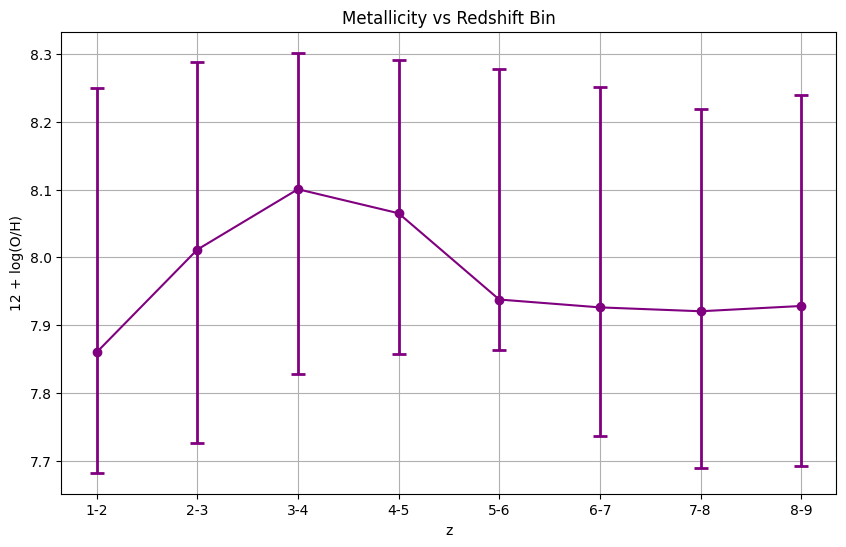

In [58]:
q_master = np.array(q_master)
redshift_bins = ['1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9']

fig, ax = plt.subplots(figsize=(10, 6))
lower = q_master[:,1] - q_master[:,0]
print(lower)
upper= q_master[:,2] - q_master[:,1]
error = [lower,upper]

ax.errorbar(
    range(1, 9), q_master[:,1], yerr=error, fmt='o-', 
    capsize=5, capthick=2, elinewidth=2,c = 'purple'
)

# Set x-axis labels and ticks
ax.set_xticks(range(1, 9))
ax.set_xticklabels(redshift_bins)

# Set axis labels and title
ax.set_xlabel('z')
ax.set_ylabel('12 + log(O/H)')
ax.set_title('Metallicity vs Redshift Bin')

# Add a legend and grid
ax.grid(True)

# Show the plot
plt.show()


In [ ]:
stacked_table = Table({'FLUX':wt_avg_master,
                     'WAVELENGTH':stacked_wavelength,
                     'FLUX_ERROR':wt_err_master})
stacked_table.write('STACKED_SPECTRA.fits',overwrite=True) 

In [ ]:
stacked_table = Table.read('STACKED_SPECTRA.fits')
stacked_table